# Forcasting Housing Market Prices Using Facebook's Prophet 


This is a light demo code as the entire iteration takes ~10 hours in Google COLAB
*   Reading in the Zillow data
*   Transposing
*   Iterating over zip code
*   Finding top gainers and lLosers
*   Finding best states to explore further 




In [1]:
# Import required packages.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
#from botocore.client import Config
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib as mpl
#from  multiprocessing import Pool, cpu_count
import pandas as pd
import numpy as np
#import ibm_boto3
import itertools
import types
#import math
#import time
import plotly.express as px
plt.style.use('fivethirtyeight')
sns.set(rc={'figure.figsize':(11.7,8.27)})
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv')
print(len(df))
df.head()

30464


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872.0,1487969.0,1480591.0,1471324.0,1462476.0,1456223.0,1448110.0,1446622.0,1451579.0,1452858.0,1453112.0,1439554.0,1426900.0,1416568.0,1415022.0,1414474.0,1413747.0,1405862.0,1402547.0,1390420.0,1381621.0,1375725.0,1374714.0,1381453.0,1385737.0,1389268.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547.0,968807.0,968566.0,969572.0,972936.0,973010.0,972447.0,972684.0,975094.0,978629.0,981362.0,979667.0,976810.0,975419.0,975366.0,975741.0,974693.0,975616.0,975734.0,975251.0,974238.0,973104.0,971908.0,972038.0,973671.0,975642.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601.0,1578799.0,1585506.0,1587796.0,1591265.0,1596660.0,1598258.0,1596017.0,1595032.0,1592948.0,1590038.0,1576594.0,1562766.0,1552128.0,1545711.0,1540137.0,1528603.0,1514894.0,1502233.0,1492429.0,1486122.0,1480426.0,1476509.0,1478980.0,1479301.0,1474994.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470.0,333247.0,333699.0,334667.0,335386.0,335194.0,335478.0,335777.0,336150.0,336558.0,336390.0,336776.0,336806.0,336869.0,336217.0,335679.0,335536.0,335878.0,335940.0,336092.0,336119.0,336083.0,336154.0,335860.0,336037.0,336483.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,120

In [3]:
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [4]:
df1 =df

In [5]:
## SOME BASIC TIME DF MANIPULATION
# remove unwanted cols
df = df1.drop(columns = ['RegionID','City','State','Metro','CountyName','SizeRank','RegionType','StateName'])
# convert zip code to col names
df = df.set_index('RegionName')
# transpose time series matrices
df = df.T
# convert indices to date time
df.index = pd.to_datetime(df.index)
#df = df.dropna()
#df['ds'] = df.index
df=df.reset_index(level=0)
df

RegionName,index,10025,60657,10023,77494,60614,77449,10002,77084,79936,60640,11226,10467,78660,94109,00926,10016,37013,32162,60647,11201,11235,11375,90250,78130,37211,10029,10009,77573,60618,77584,10011,20002,10128,28269,78613,77433,78572,30349,79912,...,08541,02714,01615,52204,56210,02912,32511,25305,32072,55144,21405,63875,86343,20052,75599,00501,01063,03575,20635,22807,02203,93282,40404,89155,84322,95229,73019,95721,77399,38959,04420,04109,07703,00742,00803,00802,00820,00822,00831,00851
0,1996-01-31,NaN,364892.0,NaN,200475.0,546663.0,97521.0,NaN,97381.0,82374.0,254388.0,219465.0,239931.0,144867.0,616693.0,NaN,NaN,110296.0,109755.0,170128.0,510476.0,230762.0,293530.0,170408.0,NaN,110050.0,NaN,NaN,NaN,220733.0,138183.0,NaN,144172.0,NaN,130817.0,166847.0,161268.0,NaN,94712.0,124293.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,418753.0,NaN,71548.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193704.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-02-29,NaN,364162.0,NaN,200723.0,546231.0,97513.0,NaN,97405.0,82330.0,252774.0,218301.0,239200.0,144705.0,621942.0,NaN,NaN,110744.0,110669.0,170608.0,511157.0,230155.0,291813.0,170715.0,NaN,110378.0,NaN,NaN,NaN,220549.0,138336.0,NaN,142533.0,NaN,130876.0,166368.0,161478.0,NaN,95222.0,124084.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70249.0,420003.0,NaN,70971.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-03-31,NaN,363605.0,NaN,200526.0,545451.0,97471.0,NaN,97330.0,82300.0,251468.0,217211.0,238902.0,144605.0,625642.0,NaN,NaN,111127.0,110830.0,171100.0,511756.0,230408.0,290892.0,171065.0,NaN,110717.0,NaN,NaN,NaN,220433.0,138904.0,NaN,141625.0,NaN,131044.0,165657.0,161583.0,NaN,95625.0,123981.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69615.0,419014.0,NaN,70884.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-04-30,NaN,362963.0,NaN,199337.0,545391.0,97491.0,NaN,97323.0,82263.0,248948.0,215847.0,237644.0,144509.0,629519.0,NaN,NaN,111920.0,111554.0,171895.0,513792.0,231098.0,289045.0,171689.0,NaN,111428.0,NaN,NaN,NaN,220919.0,139582.0,NaN,139416.0,NaN,131543.0,164537.0,162037.0,NaN,96459.0,123801.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69249.0,419297.0,NaN,70868.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-05-31,NaN,361660.0,NaN,198200.0,543066.0,97486.0,NaN,97280.0,82344.0,246695.0,215392.0,237158.0,144543.0,630085.0,NaN,NaN,112740.0,111591.0,171957.0,513345.0,232541.0,288202.0,172288.0,NaN,112133.0,NaN,NaN,NaN,220817.0,140240.0,NaN,138181.0,NaN,132201.0,163449.0,162341.0,NaN,97204.0,123879.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68326.0,417464.0,NaN,71459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2019-11-30,1375725.0,973104.0,1480426.0,336083.0,1201182.0,187978.0,1260484.0,185299.0,133748.0,728915.0,1077017.0,527675.0,269270.0,3091849.0,102502.0,1349680.0,245482.0,284566.0,524777.0,3232986.0,873683.0,1139949.0,661550.0,242156.0,282896.0,945091.0,1394851.0,284191.0,515065.0,274265.0,3069735.0,751261.0,5335230.0,228352.0,337358.0,281960.0,121707.0,160335.0,197137.0,...,729023.0,324411.0,111906.0,188031.0,52895.0,116404.0,190518.0,59502.0,78601.0,240917.0,957540.0,80974.0,163709.0,1349835.0,91714.0,79265.0,629988.0,432045.0,220867.0,241386.0,50241.0,139025.0,129184.0,379157.0,353309.0,239002.0,198517.0,294132.0,104598.0,32507.0,374221.0,625528.0,672346.0,301744.0,125697.0,130717.0,101363.0,175176.0,74273.0,450047.0
287,2019-12-31,1374714.0,971908.0,147

In [ ]:
df = df.loc[:,~df.columns.duplicated()]

In [16]:
cols = df.columns.tolist()[1:]
results = []
#print(cols)
print(len(cols))

30464


# Iterating over zip code
*   Note this is just a subset due to long runtime
*   Dealing with missing data and tuning the forecast is recommended
*   Data trains up to 2017 and calculate the percent gain for 2018


In [7]:
results = []
pred_changes = []
actual_changes=[]
pct_changes = []
zips = []
maes= []
mses = []
r2s = []

from tqdm.notebook import tqdm

for i in tqdm(range(15001, 15500), position=0, leave=True):
    col = cols[i]

#for col in cols[0:100]:
    subdf = df[['index', col]].dropna()
    subdf = subdf.rename(columns={'index':'ds', col:'y'})
    dftrain=subdf.query('ds < "2018-01-31"')
    if len(dftrain) < 12:
      continue
    dftest=subdf.query('ds >= "2018-01-31"')
    #print(subdf)
    m = Prophet(interval_width=.95, changepoint_prior_scale=6, yearly_seasonality=True, uncertainty_samples =100) 
    m.fit(dftrain)
    df_pred = pd.DataFrame({'ds': dftest['ds']})
    result = m.predict(df_pred)
    subdf.set_index('ds', drop=True, inplace=True)
    result.set_index('ds', drop=True, inplace=True)
    pred_change = result.loc['2018-12-31', 'yhat'] - subdf.loc['2017-12-31', 'y']
    actual_change = subdf.loc['2018-12-31', 'y'] - subdf.loc['2017-12-31', 'y']
    pct_change = (pred_change/subdf.loc['2017-12-31', 'y'])
    mae_prophet = mean_absolute_error(dftest['y'],result['yhat'])
    mse_prophet = mean_squared_error(dftest['y'],result['yhat'])
    r2_prophet = r2_score(dftest['y'],result['yhat'])
    pred_changes.append(pred_change)
    actual_changes.append(actual_change)
    maes.append(mae_prophet)
    mses.append(pred_change)
    r2s.append(r2_prophet)
    pct_changes.append(pct_change)
    zips.append(col)

df_res = pd.DataFrame({'zip': zips, 'pred_change': pred_changes, 'actual_change': actual_changes,
                       'pct_change': pct_changes, 'mae': maes, 'mse': mses, 'r2': r2s})
df_res.to_csv('demo.csv', index=False)

  0%|          | 0/499 [00:00<?, ?it/s]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
# Combine the data together again

res1 = pd.read_csv('results10000.csv')
res2 = pd.read_csv('results15000.csv')
res3 = pd.read_csv('results20000.csv')
res4 = pd.read_csv('results25000.csv')
res5 = pd.read_csv('results30464.csv')

results = pd.concat([res1, res2, res3, res4, res5], ignore_index=True)
results.to_csv('results_combined.csv', index=False)

In [8]:
results_combined = pd.read_csv('demo.csv')
results_combined['zip'] = results_combined['zip'].astype(str).str.zfill(5)

In [9]:
top5 = results_combined.sort_values(by=['pct_change']).tail(5)
low5 = results_combined.sort_values(by=['pct_change']).head(5)
poles = pd.concat([top5, low5], ignore_index=True)
poles = poles.sort_values(by=['pct_change'],ascending=True)

In [10]:
poles=poles.merge(df1, left_on = 'zip', right_on = 'RegionName')
poles.shape

(10, 307)

In [11]:
poles['Gain/Loss'] = poles['pct_change'].gt(0).replace({True: 'Gain', False: 'Loss'})

In [12]:
plt.style.use('fivethirtyeight')

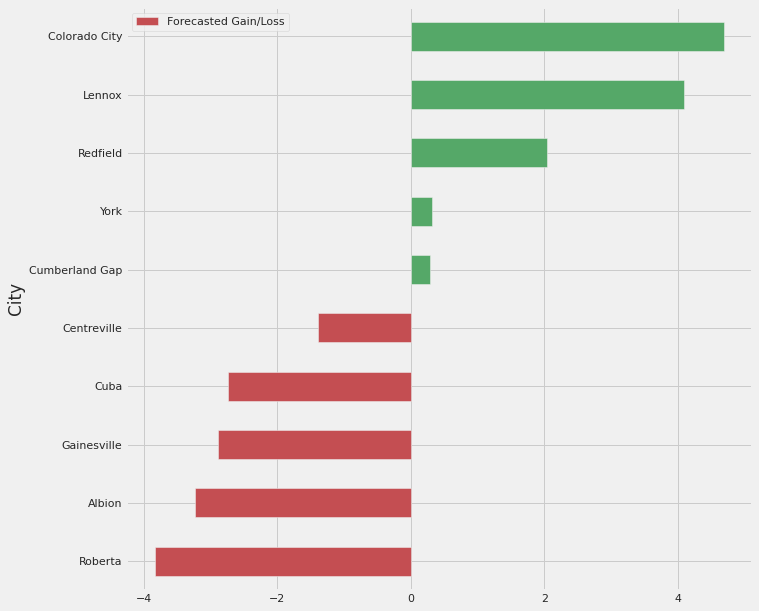

In [13]:
import numpy as np
colormat=np.where(poles['pct_change']>0, 'g','r')
poles.plot.barh(x='City', y='pct_change', rot=0, color=colormat,figsize=(10,10),xlabel="City",label='Forecasted Gain/Loss') 

In [14]:
pct_map=results_combined.merge(df1, left_on = 'zip', right_on = 'RegionName')
map3=pct_map.groupby(['State']).median().reset_index()
us_med= map3[['State','pct_change']]

In [15]:
fig1 = px.choropleth(us_med,
                    locations='State',
                    color='pct_change',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'TotalPay':'Median House Value'},
                    title="Median Forecasted Percent Change from 2017-2018",
                    scope='usa')
fig1.update_layout(
    title={
        'text': "Median Forecasted Percent Change from 2017-2018",
        'y':0.9,
        'x':0.46,
        'xanchor': 'center',
        'yanchor': 'top'})

fig1.show()